In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from random import shuffle

/sw/anaconda-5.3/python3.7/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


ModuleNotFoundError: No module named 'tensorflow'

# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [2]:
tsla_data = pd.read_csv('./TSLA.csv')
goog_data = pd.read_csv('./GOOGL.csv')
dji_data = pd.read_csv('./DJI.csv')

## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [3]:
scaler = MinMaxScaler()
tsla_open = scaler.fit_transform(tsla_data.iloc[:,1:])[:,0]
goog_open = scaler.fit_transform(goog_data.iloc[:, 1:])[:,0]
dji_open = scaler.fit_transform(dji_data.iloc[:,1:])[:,0]

/sw/anaconda-5.3/python3.7/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/sw/anaconda-5.3/python3.7/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/sw/anaconda-5.3/python3.7/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(8636,)
(2227,)
(3702,)


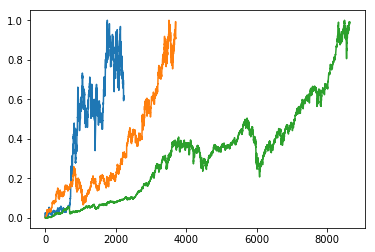

In [4]:
# quick viz
plt.plot(tsla_open)
plt.plot(goog_open)
plt.plot(dji_open)
print(dji_open.shape)
print(tsla_open.shape)
print(goog_open.shape)


# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [5]:
def split(data, size):
    """
    If data is a list, will split all (e.g. we use all the tsla, goog, dji data)
    Parameters:
        -data: 1D numpy array of opening price
        -size: how many days back to use
    Outputs:
        -
    """
    if isinstance(data, list):
        print('Data is in list, concatenating...')
        l_data = []
        for d in data:
            # select size + 1 (for "label")
            for i in range(0, len(d) - size, size+1):
                l_data.append(d[i:i + size + 1])
    else:
        l_data = []
        for i in range(0, len(data) - size, size+1):
            l_data.append(data[i:i + size + 1])
    np_data = np.vstack(l_data)
    data, labels = np_data[:,:-1], np_data[:,-1]
    x_train, x_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.2)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)
    return x_train, y_train, x_val, y_val, x_test, y_test

def minibatch(data, labels, batch_size):
    start, end = 0, batch_size
    while end < len(data):
        yield data[start:end], labels[start:end]
        start += batch_size
        end += batch_size
        
        

In [334]:
num_days = 15
x_train, y_train, x_val, y_val, x_test, y_test = split([tsla_open, dji_open, goog_open], num_days)

Data is in list, concatenating...


In [335]:
# reshape to [-1, num_steps=num_days, num_inputs=1]
x_train_1 = np.reshape(x_train, (-1, num_days, 1))
y_train_1 = np.reshape(y_train, (-1, 1))


# TensorFlow Model

In [388]:
# hyperparameters
num_epochs = 25
batch_size = 16
lr = 0.001

# model parameters
tf.reset_default_graph()
num_steps = num_days # number of days to use to predict
num_inputs = 1 # scalar input (open price)
num_neurons = 128 # recurrent neurons per cell
num_outputs = 1

# construct the graph
tf.reset_default_graph()

# placeholders for input stock data open prices
X = tf.placeholder(tf.float32, shape=[None, num_steps, num_inputs])
Y = tf.placeholder(tf.float32, shape=[None])

# RNN
cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32) #unwrap

# fully connected layer at end-state to get scalar prediction of next stock value
pred = tf.layers.dense(states[0], num_outputs) # have to index into state to get hidden state for prediction use

# loss
loss = tf.reduce_mean(tf.square(pred - Y))
opt = tf.train.AdamOptimizer(learning_rate=lr)
minimize = opt.minimize(loss)


# Training

In [389]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        print('Training on Epoch: \t' + str(epoch))
        batcher = minibatch(x_train_1, y_train, batch_size)
        for data, labels in batcher:
            f_dict = {X: data, Y:labels}
            sess.run(minimize, feed_dict=f_dict)
            if epoch == 0:
                print(sess.run(loss, feed_dict=f_dict))
        print(sess.run(loss, feed_dict=f_dict))
    print("Test Loss")
    print(sess.run(loss, feed_dict={X:np.reshape(x_test, (-1,num_days,1)), Y:y_test}))
    to_test = sess.run(pred, feed_dict={X:np.reshape(x_test, (-1,num_days,1)), Y:y_test})

Training on Epoch: 	0
0.16939268
0.12762177
0.08731702
0.09453079
0.09675355
0.05914352
0.14754795
0.1089738
0.11743535
0.11825759
0.10110399
0.07753515
0.09270291
0.10705002
0.059836224
0.07205818
0.08316495
0.07298614
0.083073415
0.08019858
0.043361194
0.09722697
0.056162763
0.07844899
0.0445942
0.056142967
0.07451714
0.081040695
0.04191321
0.08904119
0.08382357
0.047257982
0.029100303
0.04778181
0.05759179
0.048664298
0.100680895
0.04605879
0.047646105
0.03759158
0.0690467
0.0703595
0.060599033
0.061712984
0.04262873
0.04262873
Training on Epoch: 	1
0.044815302
Training on Epoch: 	2
0.044959843
Training on Epoch: 	3
0.044920944
Training on Epoch: 	4
0.04484482
Training on Epoch: 	5
0.0447325
Training on Epoch: 	6
0.044568535
Training on Epoch: 	7
0.04437954
Training on Epoch: 	8
0.044201136
Training on Epoch: 	9
0.044054255
Training on Epoch: 	10
0.04396078
Training on Epoch: 	11
0.04388859
Training on Epoch: 	12
0.043798532
Training on Epoch: 	13
0.04370903
Training on Epoch: 	14
0

# Testing

(0, 1)

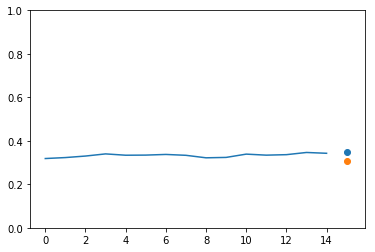

In [394]:
# check stuff out
val = 52
plt.figure()
plt.plot(x_test[val])
plt.scatter(len(x_test[val]), y_test[val])
plt.scatter(len(x_test[val]), to_test[val])
plt.ylim(0,1)